In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse493g1/assignments/assignment2/'
FOLDERNAME = 'cse493g1/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cse493g1/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/datasets
/content/drive/My Drive/cse493g1/assignments/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cse493g1/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cse493g1/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from the previous notebook.


In [ ]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cse493g1.classifiers.fc_net import *
from cse493g1.data_utils import get_CIFAR10_data
from cse493g1.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cse493g1.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [ ]:
np.random.seed(493)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.299821914918452
W1 relative error: 9.656953386228676e-08
W2 relative error: 4.42914245511279e-06
W3 relative error: 1.4112116043233687e-06
b1 relative error: 9.10105007110364e-09
b2 relative error: 1.3597116499374134e-07
b3 relative error: 1.3432054300218008e-10
Running check with reg =  3.14
Initial loss:  6.991659719884911
W1 relative error: 2.2442521861888318e-08
W2 relative error: 1.3072726683559537e-08
W3 relative error: 1.585488123924185e-08
b1 relative error: 4.368076841105884e-08
b2 relative error: 1.0110675182132624e-08
b3 relative error: 1.1311009016240723e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.302510
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.107000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.107000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.108000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.109000
(Epoch 5 / 20) train acc: 0.120000; val_acc: 0.109000
(Iteration 11 / 40) loss: 2.302563
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.108000
(Epoch 7 / 20) train acc: 0.120000; val_acc: 0.108000
(Epoch 8 / 20) train acc: 0.120000; val_acc: 0.108000
(Epoch 9 / 20) train acc: 0.120000; val_acc: 0.110000
(Epoch 10 / 20) train acc: 0.120000; val_acc: 0.110000
(Iteration 21 / 40) loss: 2.302531
(Epoch 11 / 20) train acc: 0.120000; val_acc: 0.109000
(Epoch 12 / 20) train acc: 0.120000; val_acc: 0.109000
(Epoch 13 / 20) train acc: 0.120000; val_acc: 0.109000
(Epoch 14 / 20) train acc: 0.120000; val_acc: 0.109000
(Epoch 15 / 20) train acc: 0.120000; val_acc: 0.108000
(Iteration 31 / 40) loss: 

/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/layers.py:205: RuntimeWarning: overflow encountered in exp
  x = np.exp(x)
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/layers.py:207: RuntimeWarning: invalid value encountered in divide
  x = x / row_sums[:,np.newaxis]
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/layers.py:210: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(loss_array))


(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 2 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 3 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 4 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 5 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 11 / 40) loss: nan
(Epoch 6 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 7 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 8 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 9 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 10 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 21 / 40) loss: nan
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 31 / 40) loss: nan
(Epoch 16 / 20) train acc: 0.080000; val

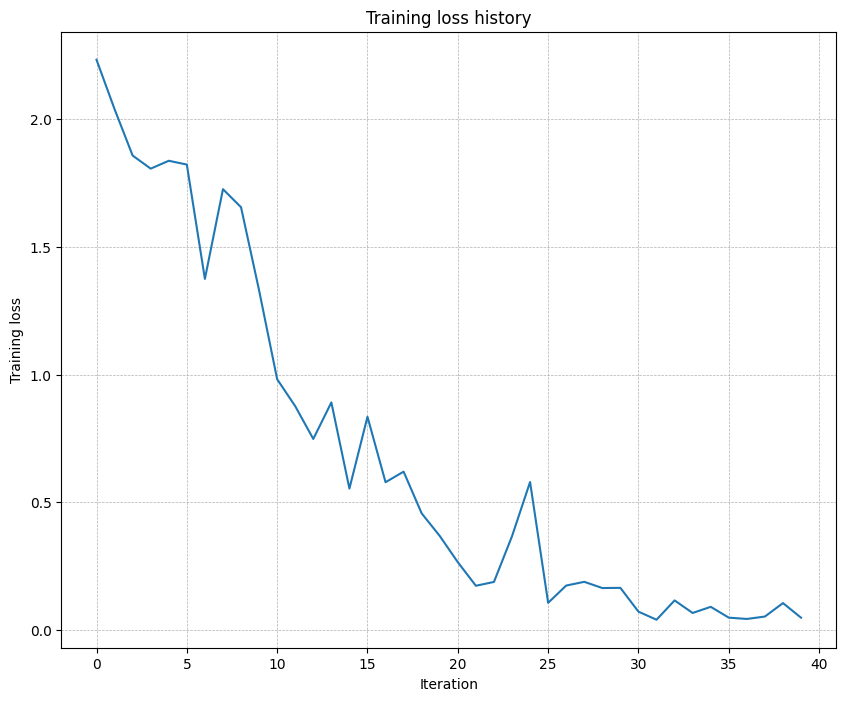

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = [1e-3,1e-2,1e-1]  # Experiment with this!
learning_rate = [1e-5,1e-4,1e-3,1e-2]  # Experiment with this!
best_net = None
results = {}
best_train = 0

for i in weight_scale:
  for j in learning_rate:
    model = FullyConnectedNet(
        [100, 100],
        weight_scale=i,
        dtype=np.float64
    )
    solver = Solver(
        model,
        small_data,
        print_every=10,
        num_epochs=20,
        batch_size=25,
        update_rule="sgd",
        optim_config={"learning_rate": j},
    )
    solver.train()

    if solver.train_acc_history[len(solver.train_acc_history) - 1] > best_train:
        best_net = model
        best_solver = solver
        best_train = solver.train_acc_history[len(solver.train_acc_history) - 1]

    results[(i,j)] = (solver.train_acc_history[len(solver.train_acc_history) - 1], solver.best_val_acc)

# Print out results.
for i, j in sorted(results):
    train_accuracy, val_accuracy = results[(i,j)]
    print('weight_scale  %e lr %e train accuracy: %f val accuracy: %f' % (
                i, j, train_accuracy, val_accuracy))

print('best train accuracy achieved: %f' % best_train)

plt.plot(best_solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/layers.py:210: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(loss_array))
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/layers.py:205: RuntimeWarning: overflow encountered in exp
  x = np.exp(x)
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/layers.py:207: RuntimeWarning: invalid value encountered in divide
  x = x / row_sums[:,np.newaxis]


weight_scale  1.000000e-05 lr 2.000000e-05 train accuracy: 0.160000 val accuracy: 0.112000
weight_scale  1.000000e-05 lr 2.000000e-04 train accuracy: 0.160000 val accuracy: 0.119000
weight_scale  1.000000e-05 lr 2.000000e-03 train accuracy: 0.160000 val accuracy: 0.119000
weight_scale  1.000000e-05 lr 2.000000e-02 train accuracy: 0.160000 val accuracy: 0.119000
weight_scale  1.000000e-05 lr 2.000000e-01 train accuracy: 0.160000 val accuracy: 0.112000
weight_scale  1.000000e-04 lr 2.000000e-05 train accuracy: 0.160000 val accuracy: 0.112000
weight_scale  1.000000e-04 lr 2.000000e-04 train accuracy: 0.160000 val accuracy: 0.112000
weight_scale  1.000000e-04 lr 2.000000e-03 train accuracy: 0.160000 val accuracy: 0.079000
weight_scale  1.000000e-04 lr 2.000000e-02 train accuracy: 0.160000 val accuracy: 0.119000
weight_scale  1.000000e-04 lr 2.000000e-01 train accuracy: 0.160000 val accuracy: 0.079000
weight_scale  1.000000e-03 lr 2.000000e-05 train accuracy: 0.160000 val accuracy: 0.112000

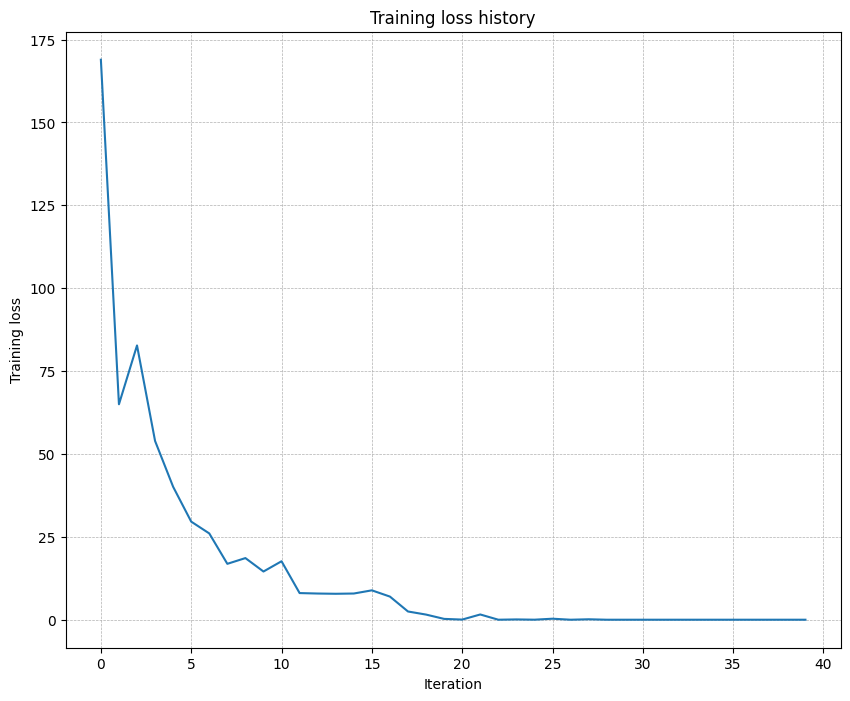

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


weight_scale = [1e-5,1e-4,1e-3,1e-2,1e-1]  # Experiment with this!
learning_rate = [2e-5,2e-4,2e-3,2e-2,2e-1]  # Experiment with this!
best_net = None
results = {}
best_train = 0

for i in weight_scale:
  for j in learning_rate:
    model = FullyConnectedNet(
        [100, 100, 100, 100],
        weight_scale = i,
        dtype=np.float64
    )
    solver = Solver(
        model,
        small_data,
        print_every=10,
        num_epochs=20,
        batch_size=25,
        update_rule="sgd",
        optim_config={"learning_rate": j},
        verbose = False,
    )
    solver.train()

    if solver.train_acc_history[len(solver.train_acc_history) - 1] > best_train:
        best_net = model
        best_solver = solver
        best_train = solver.train_acc_history[len(solver.train_acc_history) - 1]

    results[(i,j)] = (solver.train_acc_history[len(solver.train_acc_history) - 1], solver.best_val_acc)

# Print out results.
for i, j in sorted(results):
    train_accuracy, val_accuracy = results[(i,j)]
    print('weight_scale  %e lr %e train accuracy: %f val accuracy: %f' % (
                i, j, train_accuracy, val_accuracy))

print('best train accuracy achieved: %f' % best_train)

plt.plot(best_solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1:
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:

The five-layer network seems to be significantly more effected by initialization than the three layer one. This can be seen in our hyperparameter tuning where we get high training accuracies for multiple values of weight_scale in the three layer network (1e-2 and 1e-1) while for the five layer network only one value gives above 20% accuracy on the training set.

The reason for this could be vanishing or exploding gradients as more layers are added to the network. The more layers in the network, the more gradients are multiplied during backpropagation to get gradients for say the first layer parameters. Repeatedly mutliplying by a very small quanitity could make these gradients almost zero, halting learning. Similarly, multiplying by large quanitites repeatedly could explode the gradient and increase step sizes significanlty, causing the parameters to overshoot optimal points.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section for more information.

Open the file `cse493g1/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [ ]:
from cse493g1.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.848659
(Epoch 0 / 5) train acc: 0.089000; val_acc: 0.092000
(Iteration 11 / 200) loss: 2.276126
(Iteration 21 / 200) loss: 2.226377
(Iteration 31 / 200) loss: 2.143061
(Epoch 1 / 5) train acc: 0.213000; val_acc: 0.203000
(Iteration 41 / 200) loss: 2.032144
(Iteration 51 / 200) loss: 2.184910
(Iteration 61 / 200) loss: 2.077225
(Iteration 71 / 200) loss: 1.883723
(Epoch 2 / 5) train acc: 0.291000; val_acc: 0.250000
(Iteration 81 / 200) loss: 2.118058
(Iteration 91 / 200) loss: 1.966213
(Iteration 101 / 200) loss: 2.099373
(Iteration 111 / 200) loss: 2.010937
(Epoch 3 / 5) train acc: 0.316000; val_acc: 0.277000
(Iteration 121 / 200) loss: 1.881235
(Iteration 131 / 200) loss: 1.941409
(Iteration 141 / 200) loss: 1.844409
(Iteration 151 / 200) loss: 1.925058
(Epoch 4 / 5) train acc: 0.334000; val_acc: 0.285000
(Iteration 161 / 200) loss: 1.762348
(Iteration 171 / 200) loss: 1.855890
(Iteration 181 / 200) loss: 1.684910
(Iteration 191 / 200) los

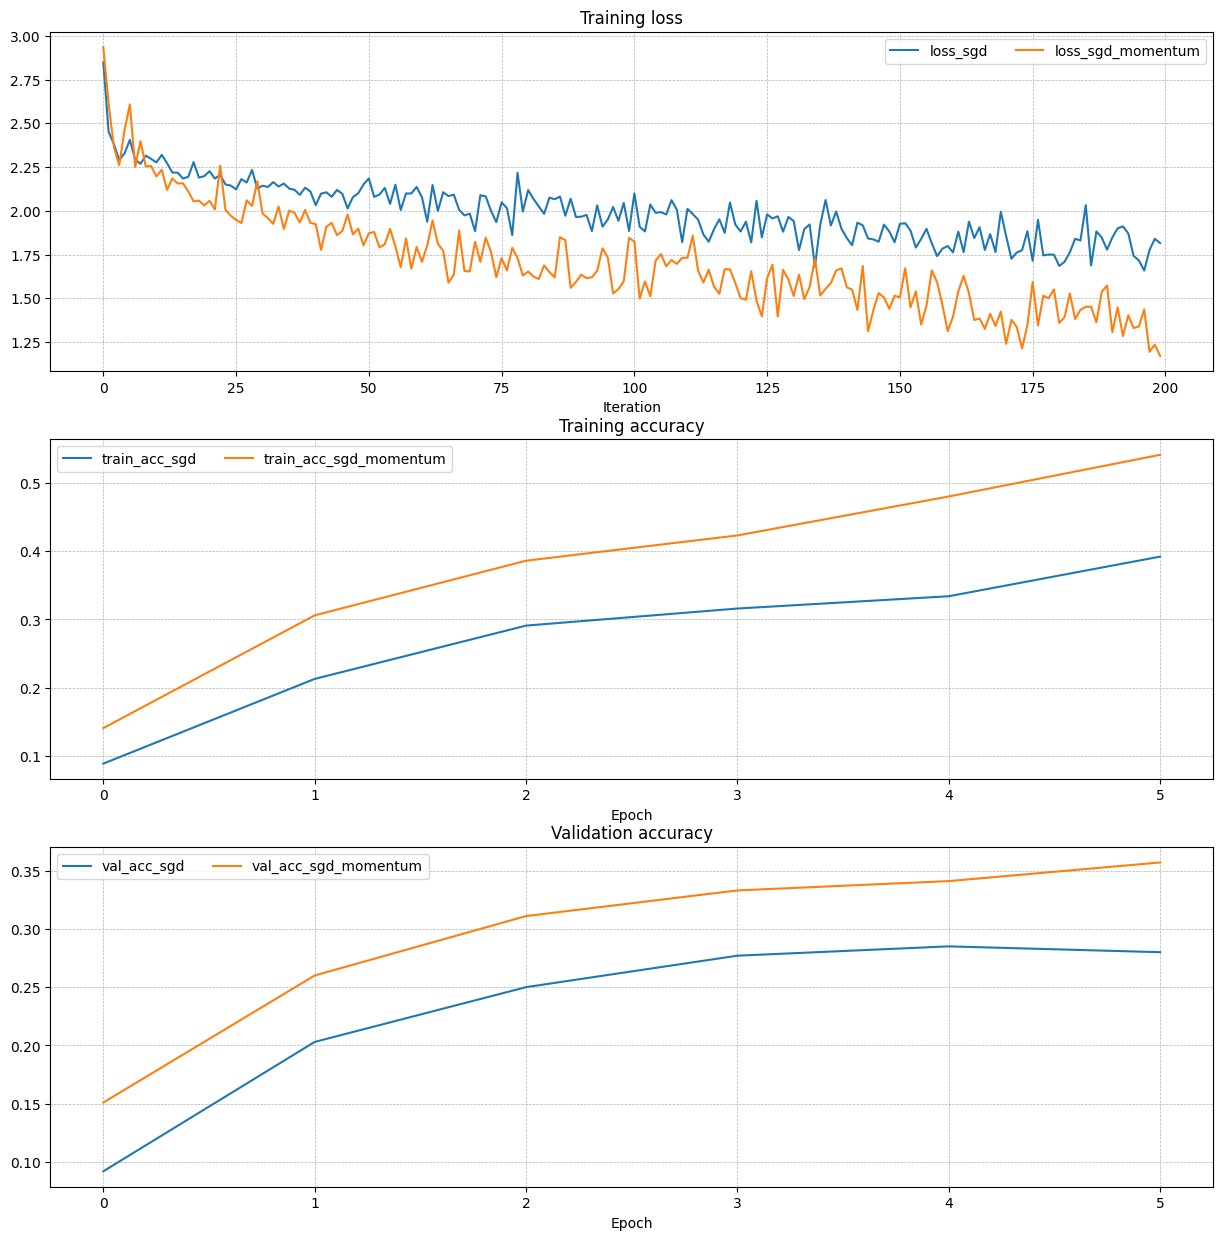

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cse493g1/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation
from cse493g1.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [ ]:
# Test Adam implementation
from cse493g1.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.750324
(Epoch 0 / 5) train acc: 0.144000; val_acc: 0.147000
(Iteration 11 / 200) loss: 2.111620
(Iteration 21 / 200) loss: 2.021784
(Iteration 31 / 200) loss: 1.820050
(Epoch 1 / 5) train acc: 0.345000; val_acc: 0.302000
(Iteration 41 / 200) loss: 1.792357
(Iteration 51 / 200) loss: 1.654000
(Iteration 61 / 200) loss: 1.713413
(Iteration 71 / 200) loss: 1.607876
(Epoch 2 / 5) train acc: 0.429000; val_acc: 0.347000
(Iteration 81 / 200) loss: 1.593302
(Iteration 91 / 200) loss: 1.526982
(Iteration 101 / 200) loss: 1.610553
(Iteration 111 / 200) loss: 1.574223
(Epoch 3 / 5) train acc: 0.481000; val_acc: 0.361000
(Iteration 121 / 200) loss: 1.408578
(Iteration 131 / 200) loss: 1.412894
(Iteration 141 / 200) loss: 1.400828
(Iteration 151 / 200) loss: 1.362720
(Epoch 4 / 5) train acc: 0.528000; val_acc: 0.350000
(Iteration 161 / 200) loss: 1.222563
(Iteration 171 / 200) loss: 1.280718
(Iteration 181 / 200) loss: 1.119981
(Iteration 191 / 200) lo

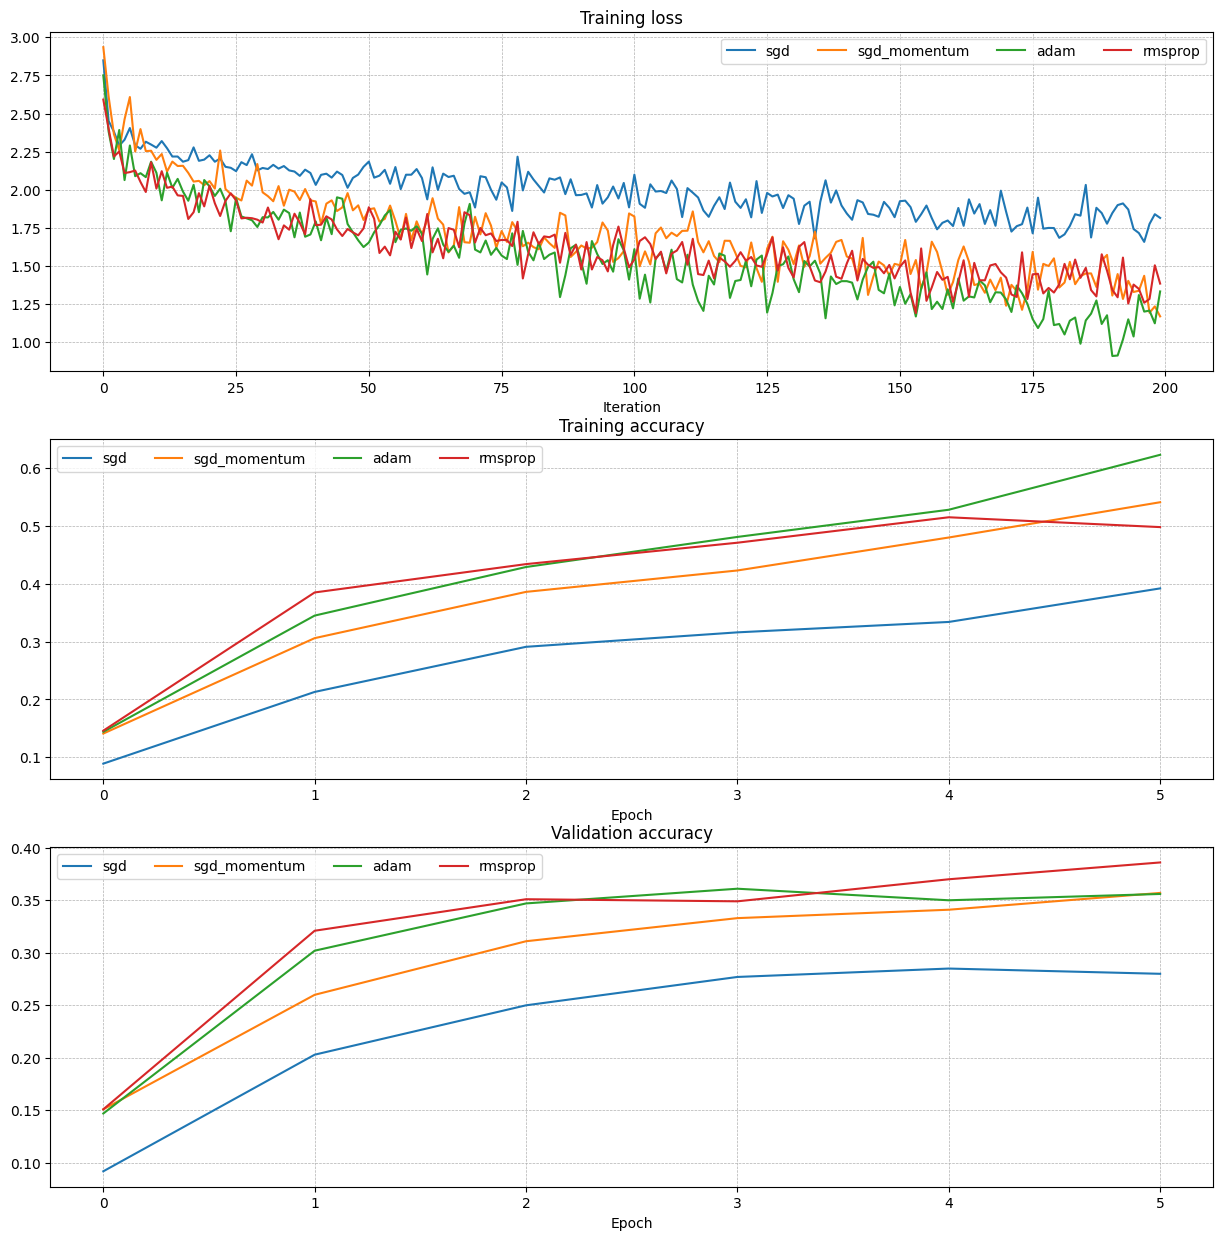

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:
As number of iterations increase, the running sum of gradients keeps increasing for AdaGrad. This being in the denominator, makes the step size very small at higher iterations.

Adam, on the other hand, maintains a convex running sum of gradients - i.e. it discounts previous gradients by a factor. This means that the value in the denominator does not shoot up with iterations and thus update size doesn't decay to zero.


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

(Iteration 1 / 39200) loss: 99.066483
(Epoch 0 / 20) train acc: 0.106000; val_acc: 0.120000
(Iteration 11 / 39200) loss: 22.709656
(Iteration 21 / 39200) loss: 20.675154
(Iteration 31 / 39200) loss: 21.862113
(Iteration 41 / 39200) loss: 17.847248
(Iteration 51 / 39200) loss: 12.737599
(Iteration 61 / 39200) loss: 15.188730
(Iteration 71 / 39200) loss: 14.560160
(Iteration 81 / 39200) loss: 14.545472
(Iteration 91 / 39200) loss: 13.461726
(Iteration 101 / 39200) loss: 8.077403
(Iteration 111 / 39200) loss: 10.187128
(Iteration 121 / 39200) loss: 11.901740
(Iteration 131 / 39200) loss: 8.659592
(Iteration 141 / 39200) loss: 8.604644
(Iteration 151 / 39200) loss: 7.843852
(Iteration 161 / 39200) loss: 9.953966
(Iteration 171 / 39200) loss: 8.347199
(Iteration 181 / 39200) loss: 6.805345
(Iteration 191 / 39200) loss: 9.136222
(Iteration 201 / 39200) loss: 8.536735
(Iteration 211 / 39200) loss: 6.522159
(Iteration 221 / 39200) loss: 8.543658
(Iteration 231 / 39200) loss: 8.153820
(Iteratio

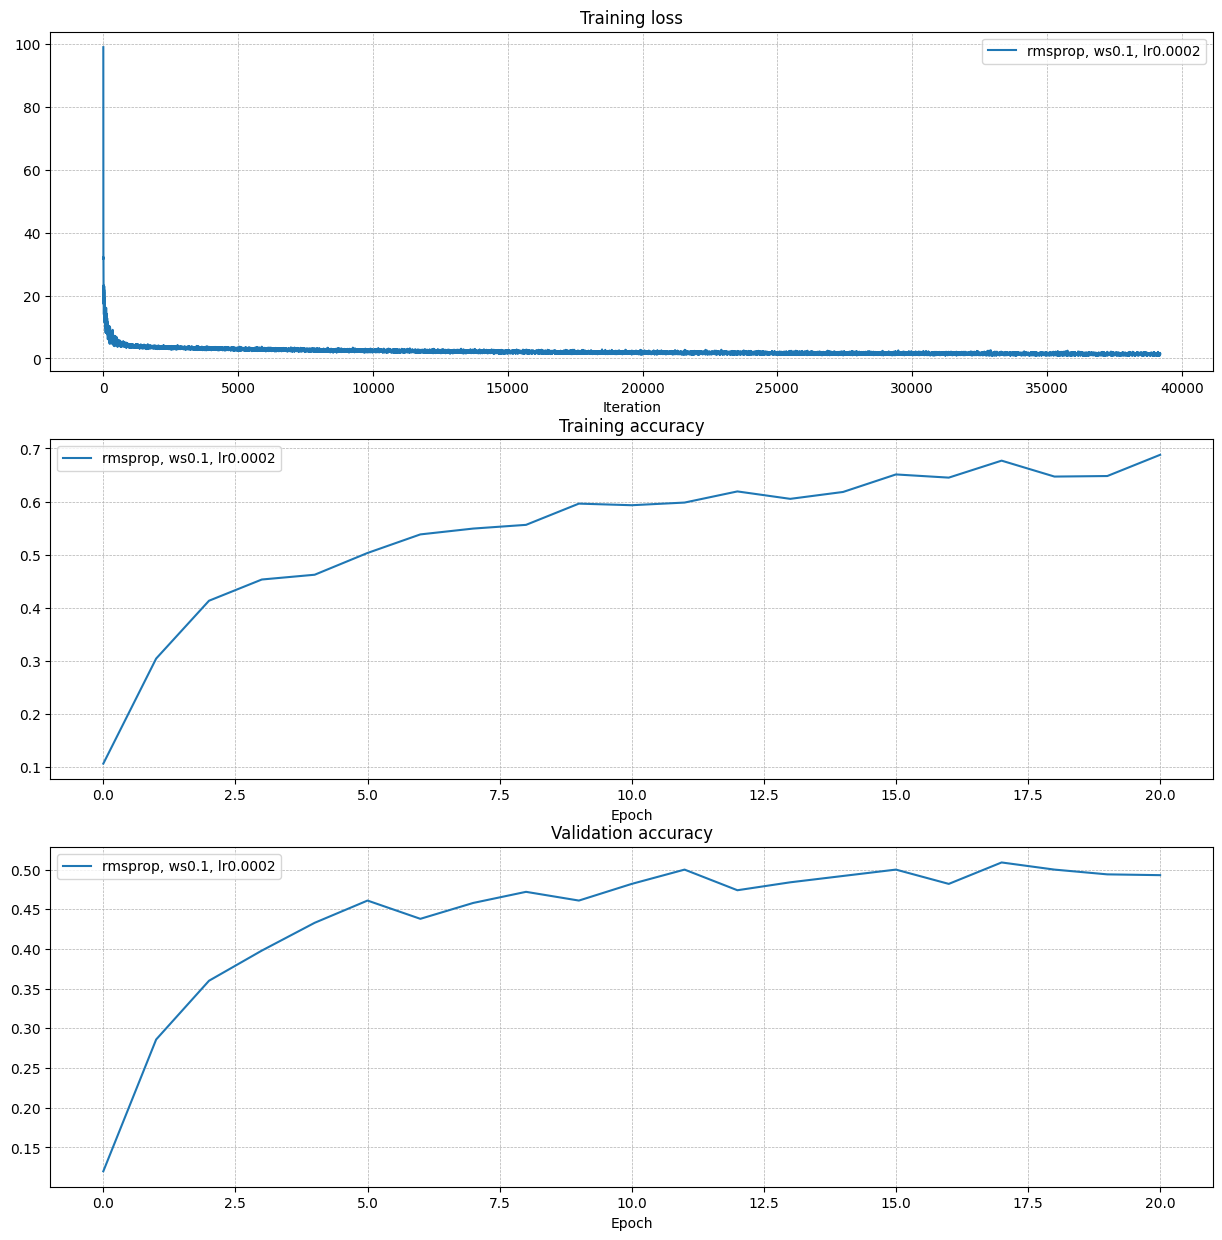

In [ ]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# weight_scale = [1e-2,1e-1]
# learning_rate = [2e-4,11e-4,2e-3]
# update_rule = ['sgd_momentum', 'adam', 'rmsprop']
# reg = [1e-1, 1e-2, 1, 1e1, 1e2]

weight_scale = [1e-1]
learning_rate = [2e-4]
update_rule = ['rmsprop']
reg = [1e-3]

results = {}
best_val = 0
best_solver = None
solvers = {}

for i in weight_scale:
  for j in learning_rate:
    for rule in update_rule:
      model = FullyConnectedNet(
          [100, 100, 100, 100, 100],
          weight_scale = i,
          dtype=np.float64,
          reg = reg[0],
      )
      solver = Solver(
          model,
          data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule= rule,
          optim_config={"learning_rate": j},
      )
      solver.train()

      solvers[(i,j,rule)] = solver

      if solver.best_val_acc > best_val:
          best_model = model
          best_solver = solver
          best_val = solver.best_val_acc

      results[(i,j,rule)] = (solver.train_acc_history[len(solver.train_acc_history) - 1], solver.best_val_acc)

# Print out results.
for i, j, rule in sorted(results):
    train_accuracy, val_accuracy = results[(i,j,rule)]
    print('weight_scale  %e lr %e rule %s train accuracy: %f val accuracy: %f' % (
                i, j, rule, train_accuracy, val_accuracy))

print('best val accuracy achieved: %f' % best_val)

# Print out results.
for i, j, rule in sorted(results):
    train_accuracy, val_accuracy = results[(i,j,rule)]
    print('weight_scale  %e lr %e rule %s train accuracy: %f val accuracy: %f' % (
                i, j, rule, train_accuracy, val_accuracy))

print('best val accuracy achieved: %f' % best_val)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for (i,j, update_rule), solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}, ws{i}, lr{j}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}, ws{i}, lr{j}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}, ws{i}, lr{j}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.509
Test set accuracy:  0.519
